In [1]:
import utils
import json
from mapboxfetcher import MapBoxFetcher
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import PIL
import pickle
from treemodel import TreeModel
import imagefunctions
from keras.models import load_model
from skimage.morphology import opening
from skimage.morphology import disk, square
import os.path
import cv2
%load_ext autoreload
%autoreload 2

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
geojson = json.load(open('Vaud.geojson'))
polygon = utils.polygon_union(geojson['features'])
bounds = polygon.bounds
zoom = 16

In [3]:
lat, lon = bounds[3], bounds[0]
start_numx, start_numy = utils.deg2num(lat, lon, zoom)
numx, numy = start_numx, start_numy

In [9]:
c_y = 23122
with open('Data/Predictions-Y{}.p'.format(c_y), 'rb') as f:
    y_preds = pickle.load(f)
c_item = y_preds[1]
c_x = c_item['x']
c_y = c_item['y']
c_pred = c_item['pred']
print(c_x)

33928


In [3]:
def squareCoordinatesToGeoJSON(coordinates):
    if isinstance(coordinates, np.ndarray):
        coordinates = coordinates.tolist()
    feature = {
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'Polygon',
            'coordinates': [[
                coordinates[0][::-1],
                coordinates[1][::-1],
                coordinates[2][::-1],
                coordinates[3][::-1],
                coordinates[0][::-1]
            ]]
        }
    }
    return json.dumps(feature)
def getTileCorners(x, y, zoom):
    ul = utils.num2deg(x, y, zoom)
    ur = utils.num2deg(x+1, y, zoom)
    lr = utils.num2deg(x+1, y+1, zoom)
    ll = utils.num2deg(x, y+1, zoom)
    return [ul, ur, lr, ll]
def getTileGeoJSON(x, y, zoom):
    ul, ur, lr, ll = getTileCorners(x, y, zoom)
    return squareCoordinatesToGeoJSON([ul, ur, lr, ll])
def splitTile(x, y, zoom, splits = 8):
    ul, ur, lr, ll = getTileCorners(x, y, zoom)
    lat_diff = (ul[0] - ll[0]) / splits
    long_diff = (ur[1] - ul[1]) / splits
    out = np.ndarray((splits, splits, 4, 2))
    for i in range(splits):
        for j in range(splits):
            out[i,j,:,:] = [
                [ul[0] - i*lat_diff, ul[1] + j*long_diff],
                [ul[0] - i*lat_diff, ul[1] + (j+1)*long_diff],
                [ul[0] - (i+1)*lat_diff, ul[1] + (j+1)*long_diff],
                [ul[0] - (i+1)*lat_diff, ul[1] + j*long_diff],
            ]
    return out
print(getTileGeoJSON(c_x, c_y, zoom))
print(squareCoordinatesToGeoJSON(splitTile(c_x, c_y, zoom, 16)[1,1]))

NameError: name 'zoom' is not defined

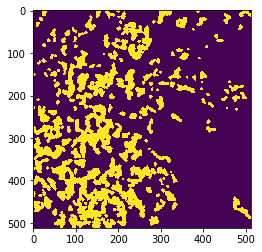

In [10]:
plt.imshow(c_pred)

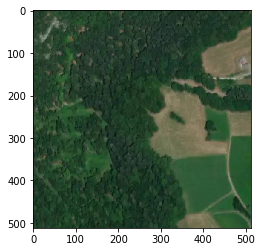

In [11]:
fetcher = MapBoxFetcher()
sat_img = fetcher.satellite(c_x, c_y, 16, hq=True)
sat_img.save('test.jpeg')
sat_img.show()

In [6]:
nn_model = load_model('NNModelOne128One256One128Layer.h5')
ada_model = pickle.load(open('TrainedModelManualZoom16.p', 'rb'))
tree_model = TreeModel(ada_model)

In [7]:
def filter(img, filter_size=3):
    return opening(img, disk(filter_size))
        
def threshold(img, threshold=0.5, mode=cv2.THRESH_BINARY):
    ret, thresh = cv2.threshold(img, threshold, 1, mode)
    return thresh

C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code2\imagefunctions.py:20: RuntimeWarning: divide by zero encountered in log
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code2\imagefunctions.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return features.as_matrix()


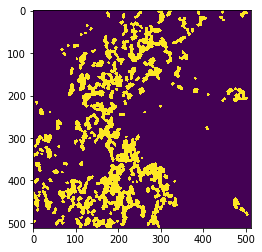

In [12]:
plt.imshow(threshold(filter(tree_model.predict_proba(sat_img.array()))))